# Merging Sessions Script

This script is used to merge two or more sessions, provided they do not contain overlapping regions of interest (ROIs).

### Prerequisites:
- Paths to two session directories with extracted shorelines.
- The desired name for the merged session directory that will be saved in the `sessions` directory.

### Optional:
- A `config.json` file with transect settings for calculating shoreline-transect intersections.

### Instructions:
1. Enter the paths to the session directories below:
    ``` python
   session_locations=[
       '<path_to_first_session_directory>',
       '<path_to_second_session_directory>'
      ]
    ```
   Example:
   - Notice that because these are Windows locations we put `r` at the beginning of each location
    ``` python
   session_locations=[
      r'C:\development\doodleverse\coastseg\CoastSeg\sessions\es1\ID_13_datetime06-05-23__04_16_45',
      r'C:\development\doodleverse\coastseg\CoastSeg\sessions\es1\ID_12_datetime06-05-23__04_16_45'
      ]
    ```
2. Specify the name for the merged session directory:
   - `merged_session_directory`: `"<name_of_merged_session_directory>"`

3. (Optional) If you want to use your own advanced settings in a `config.json` file, include its path:
   - `config_file`: `"<path_to_config_json>"`

With the above information, the script can be executed to merge the specified sessions into a single session directory.


In [5]:
session_locations=[r'C:\development\doodleverse\coastseg\CoastSeg\sessions\es1\ID_13_datetime06-05-23__04_16_45',
                   r'C:\development\doodleverse\coastseg\CoastSeg\sessions\es1\ID_12_datetime06-05-23__04_16_45']


In [6]:
merged_session_directory='merged_session_test1'

In [7]:
import os
# enter the location of your sessions directory if this is not correct
sessions_directory = os.path.join(os.getcwd(), 'sessions')
print(sessions_directory)
merged_session_location = os.path.join(sessions_directory, merged_session_directory)
os.makedirs(merged_session_location, exist_ok=True)

print(f"Merged session will be saved to {merged_session_location}")

c:\development\doodleverse\coastseg\CoastSeg\sessions
Merged session will be saved to c:\development\doodleverse\coastseg\CoastSeg\sessions\merged_session_test1


## Shoreline-Transect Intersection Analysis Settings

The default settings listed below should suffice for most use cases to find where extracted shorelines intersect transects. However, if you modified the advanced settings then you will need to adjust the settings.


Most users will want to just use the default settings listed below.

In [8]:
settings_transects ={
            "along_dist": 25,  # along-shore distance to use for computing the intersection
            "min_points": 3,  # minimum number of shoreline points to calculate an intersection
            "max_std": 15,  # max std for points around transect
            "max_range": 30,  # max range for points around transect
            "min_chainage": -100,  # largest negative value along transect (landwards of transect origin)
            "multiple_inter": "auto",  # mode for removing outliers ('auto', 'nan', 'max')
            "prc_multiple": 0.1,  # percentage of the time that multiple intersects are present to use the max
}

In [9]:
from collections import defaultdict
import os
from typing import List, Union

import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import LineString, MultiLineString, MultiPoint
from shapely.ops import unary_union

from coastseg import geodata_processing
from coastseg.file_utilities import to_file
from coastseg.common import get_cross_distance_df
from coastseg.common import convert_linestrings_to_multipoints, stringify_datetime_columns
from coastsat import SDS_transects

def convert_multipoints_to_linestrings(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Convert MultiPoint geometries in a GeoDataFrame to LineString geometries.

    Args:
    - gdf (gpd.GeoDataFrame): The input GeoDataFrame.

    Returns:
    - gpd.GeoDataFrame: A new GeoDataFrame with LineString geometries. If the input GeoDataFrame
                        already contains LineStrings, the original GeoDataFrame is returned.
    """

    # Create a copy of the GeoDataFrame
    gdf_copy = gdf.copy()

    # Check if all geometries in the gdf are LineStrings
    if all(gdf_copy.geometry.type == "LineString"):
        return gdf_copy

    def multipoint_to_linestring(multipoint):
        if isinstance(multipoint, MultiPoint):
            return LineString(multipoint.geoms)
        return multipoint

    # Convert each MultiPoint to a LineString
    gdf_copy["geometry"] = gdf_copy["geometry"].apply(multipoint_to_linestring)

    return gdf_copy

def dataframe_to_dict(df: pd.DataFrame, key_map: dict) -> dict:
    """
    Converts a DataFrame to a dictionary, with specific mapping between dictionary keys and DataFrame columns.

    Parameters:
    df : DataFrame
        The DataFrame to convert.
    key_map : dict
        A dictionary where keys are the desired dictionary keys and values are the corresponding DataFrame column names.

    Returns:
    dict
        The resulting dictionary.
    """
    result_dict = defaultdict(list)

    for dict_key, df_key in key_map.items():
        if df_key in df.columns:
            if df_key == 'date':
                # Assumes the column to be converted to date is the one specified in the mapping with key 'date'
                result_dict[dict_key] = list(df[df_key].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S") if pd.notnull(x) else None))
            elif df_key == 'geometry':
                # Assumes the column to be converted to geometry is the one specified in the mapping with key 'geometry'
                result_dict[dict_key] = list(df[df_key].apply(lambda x: np.array([list(point.coords[0]) for point in x.geoms]) if pd.notnull(x) else None))
            else:
                result_dict[dict_key] = list(df[df_key])
    
    return dict(result_dict)

def convert_lines_to_multipoints(gdf):
    # Create a copy of the input GeoDataFrame to avoid modifying it in place
    gdf = gdf.copy()

    # Define a function to convert LineString or MultiLineString to MultiPoint
    def line_to_multipoint(geometry):
        if isinstance(geometry, LineString):
            return MultiPoint(geometry.coords)
        elif isinstance(geometry, MultiLineString):
            points = [MultiPoint(line.coords) for line in geometry]
            return MultiPoint([point for multi in points for point in multi])
        else:
            return geometry  # Return the original geometry if it's not a LineString or MultiLineString

    # Apply the conversion function to each row in the GeoDataFrame
    gdf['geometry'] = gdf['geometry'].apply(line_to_multipoint)

    return gdf

def merge_geodataframes(on, how='inner', aggregation_funcs=None,crs='epsg:4326', *gdfs):
    """
    Merges multiple GeoDataFrames based on a common column.
    
    Parameters:
    on : str or list of str
        Column name or list of column names to merge on.
    how : str, optional
        Type of merge to be performed (default is 'inner').
    aggregation_funcs : dict, optional
        Dictionary of column names to aggregation functions.
        Example: for the columns 'cloud_cover' and 'geoaccuracy', the mean aggregation function can be specified as:
        aggregation_funcs = {
            'cloud_cover': 'mean',
            'geoaccuracy': 'mean'
        }
    *gdfs : GeoDataFrames
        Variable number of GeoDataFrames to be merged.
        
    Returns:
    GeoDataFrame
        The merged GeoDataFrame with aggregated columns as specified.
    """
    if len(gdfs) < 2:
        raise ValueError("At least two GeoDataFrames must be provided for merging")

    # Set default aggregation functions if none are provided
    if aggregation_funcs is None:
        aggregation_funcs = {}
        
    # Perform the merge while applying the custom aggregation functions
    merged_gdf = gdfs[0]
    merged_gdf.set_crs(crs)
    for gdf in gdfs[1:]:
        merged_gdf = pd.merge(merged_gdf, gdf, on=on, how=how, suffixes=('_left', '_right'))

        # Apply aggregation functions
        for col, func in aggregation_funcs.items():
            col_left = f'{col}_left'
            col_right = f'{col}_right'

            # Check if the columns exist in both GeoDataFrames
            if col_left in merged_gdf.columns and col_right in merged_gdf.columns:
                # Apply the aggregation function and drop the original columns
                merged_gdf[col] = merged_gdf[[col_left, col_right]].agg(func, axis=1)
                merged_gdf = merged_gdf.drop(columns=[col_left, col_right])
                
    return merged_gdf

def read_first_geojson_file(directory:str,filenames=['extracted_shorelines_lines.geojson', 'extracted_shorelines.geojson']):
    # Loop over the filenames
    for filename in filenames:
        filepath = os.path.join(directory, filename)

        # If the file exists, read it and return the GeoDataFrame
        if os.path.exists(filepath):
            return geodata_processing.read_gpd_file(filepath)

    # If none of the files exist, raise an exception
    raise FileNotFoundError(f"None of the files {filenames} exist in the directory {directory}")

def clip_gdfs(gdfs, overlap_gdf):
    """
    Clips GeoDataFrames to an overlapping region.

    Parameters:
    gdfs : list of GeoDataFrames
        The GeoDataFrames to be clipped.
    overlap_gdf : GeoDataFrame
        The overlapping region to which the GeoDataFrames will be clipped.

    Returns:
    list of GeoDataFrames
        The clipped GeoDataFrames.
    """
    clipped_gdfs = []
    for gdf in gdfs:
        clipped_gdf = gpd.clip(gdf, overlap_gdf)
        if not clipped_gdf.empty:
            clipped_gdfs.append(clipped_gdf)
            clipped_gdf.plot()
    return clipped_gdfs

def calculate_overlap(gdf):
    # Check if the input GeoDataFrame is empty
    if not hasattr(gdf,'empty'):
        return gpd.GeoDataFrame()
    if gdf.empty:
        if hasattr(gdf,'crs'):
            return gpd.GeoDataFrame(crs=gdf.crs)
        else:
            return gpd.GeoDataFrame()
    
    # Initialize an empty list to store the results
    overlap_list = []
    
    # Loop over each pair of rows in gdf
    for i in range(len(gdf)):
        for j in range(i+1, len(gdf)):
            # Check for intersection
            if gdf.iloc[i].geometry.intersects(gdf.iloc[j].geometry):
                # Calculate the intersection
                intersection = gdf.iloc[i].geometry.intersection(gdf.iloc[j].geometry)
                
                # Create a new row with the intersection and append to the result list
                overlap_list.append({'geometry': intersection})
    
    # Create a DataFrame from the results list
    overlap_df = pd.DataFrame(overlap_list)
    
    # Convert the result DataFrame to a GeoDataFrame and set the CRS
    overlap_gdf = gpd.GeoDataFrame(overlap_df, geometry='geometry', crs=gdf.crs)
    
    return overlap_gdf

def average_multipoints(multipoints)->MultiPoint:
    """
    Calculate the average MultiPoint geometry from a list of MultiPoint geometries.
    
    This function takes a list of shapely MultiPoint geometries, ensures they all have the same number of points
    by padding shorter MultiPoints with their last point, and then calculates the average coordinates
    for each point position across all the input MultiPoint geometries. 
    
    The result is a new MultiPoint geometry that represents the average shape of the input MultiPoints.
    
    Parameters:
    multipoints (list of shapely.geometry.MultiPoint): A list of shapely MultiPoint geometries to be averaged.
    
    Returns:
    shapely.geometry.MultiPoint: A MultiPoint geometry representing the average shape of the input MultiPoints.
    
    Raises:
    ValueError: If the input list of MultiPoint geometries is empty.
    
    Example:
    >>> from shapely.geometry import MultiPoint
    >>> multipoint1 = MultiPoint([(0, 0), (1, 1), (2, 2)])
    >>> multipoint2 = MultiPoint([(1, 1), (2, 2)])
    >>> multipoint3 = MultiPoint([(0, 0), (1, 1), (2, 2), (3, 3)])
    >>> average_mp = average_multipoints([multipoint1, multipoint2, multipoint3])
    >>> print(average_mp)
    MULTIPOINT (0.3333333333333333 0.3333333333333333, 1.3333333333333333 1.3333333333333333, 2 2, 3 3)
    """
    if not multipoints:
        raise ValueError("The list of MultiPoint geometries is empty")
    
    # Find the maximum number of points in any MultiPoint
    max_len = max(len(mp.geoms) for mp in multipoints)
    
    # Pad shorter MultiPoints with their last point
    padded_multipoints = []
    for mp in multipoints:
        if len(mp.geoms) < max_len:
            padded_multipoints.append(MultiPoint(list(mp.geoms) + [mp.geoms[-1]] * (max_len - len(mp.geoms))))
        else:
            padded_multipoints.append(mp)
            
    # Calculate the average coordinates for each point
    num_multipoints = len(padded_multipoints)
    average_coords = []
    for i in range(max_len):
        avg_left = sum(mp.geoms[i].x for mp in padded_multipoints) / num_multipoints
        avg_right = sum(mp.geoms[i].y for mp in padded_multipoints) / num_multipoints
        average_coords.append((avg_left, avg_right))
        
    return MultiPoint(average_coords)

def average_columns(df, col1, col2, new_col):
    df[new_col] = df[[col1, col2]].mean(axis=1,skipna=True)
    return df

def combine_dataframes(df1, df2, join_columns):
    # Perform an outer join and mark the origin of each row
    all_rows = pd.merge(df1, df2, on=join_columns, how='outer', indicator=True)

    # Keep only the rows that are in 'df1' but not in 'df2'
    df1_unique = all_rows[all_rows['_merge'] == 'left_only']
    if 'cloud_cover_x' in df1_unique.columns and 'cloud_cover_y' in df1_unique.columns:
        df1_unique = average_columns(df1_unique, 'cloud_cover_x', 'cloud_cover_y', 'cloud_cover')
        df1_unique.drop(columns=['cloud_cover_x', 'cloud_cover_y'], inplace=True)
    if 'geoaccuracy_x' in df1_unique.columns and 'geoaccuracy_y' in df1_unique.columns:
        df1_unique = average_columns(df1_unique, 'geoaccuracy_x', 'geoaccuracy_y', 'geoaccuracy')
        df1_unique.drop(columns=['geoaccuracy_x', 'geoaccuracy_y'], inplace=True)
    df1_unique.drop(columns=['_merge'], inplace=True)
    
    # Concatenate 'df2' and the unique rows from 'df1'
    result = pd.concat([df2, df1_unique], ignore_index=True)

    def assign_geometry(row):
        if pd.isnull(row['geometry']):
            if pd.notnull(row['geometry_x']):
                return row['geometry_x']
            elif pd.notnull(row['geometry_y']):
                return row['geometry_y']
        else:
            return row['geometry']

    if 'geometry_x' in result.columns and 'geometry_y' in result.columns:
        result['geometry'] = result.apply(assign_geometry, axis=1)
        result.drop(columns=['geometry_x', 'geometry_y'], inplace=True)
    return result

def combine_geodataframes(gdf1, gdf2, join_columns, average_columns=None):
    """
    Combines two GeoDataFrames, performing an outer join and averaging specified numerical columns.

    Parameters:
    gdf1, gdf2 : GeoDataFrame
        The GeoDataFrames to combine.
    join_columns : list of str
        The columns to join on.
    average_columns : list of str, optional
        The columns to average. If None, all numerical columns with the same name in both GeoDataFrames will be averaged.

    Returns:
    GeoDataFrame
        The combined GeoDataFrame.
    """
    # Ensure that the 'geometry' column is present in both GeoDataFrames
    if 'geometry' not in gdf1.columns or 'geometry' not in gdf2.columns:
        raise ValueError("Both GeoDataFrames must have a 'geometry' column.")

    # Combine GeoDataFrames using an outer join
    combined_gdf = pd.merge(gdf1, gdf2, on=join_columns, how='outer', suffixes=('_gdf1', '_gdf2'))

    if average_columns is None:
        # List of numerical columns to be averaged
        average_columns = [
            col for col in gdf1.columns
            if col in gdf2.columns
            and col not in join_columns + ['geometry']
            and np.issubdtype(gdf1[col].dtype, np.number)
            and np.issubdtype(gdf2[col].dtype, np.number)
        ]

    # Average specified numerical columns
    for col in average_columns:
        if f'{col}_gdf1' in combined_gdf.columns and f'{col}_gdf2' in combined_gdf.columns:
            combined_gdf[col] = combined_gdf[[f'{col}_gdf1', f'{col}_gdf2']].mean(axis=1)
            combined_gdf.drop(columns=[f'{col}_gdf1', f'{col}_gdf2'], inplace=True)

    # Resolve geometry conflicts by prioritizing non-null values
    combined_gdf['geometry'] = combined_gdf['geometry_gdf1'].combine_first(combined_gdf['geometry_gdf2'])
    combined_gdf.drop(columns=['geometry_gdf1', 'geometry_gdf2'], inplace=True)

    return gpd.GeoDataFrame(combined_gdf, geometry='geometry')

def mergeRightUnique(left_df: gpd.GeoDataFrame, right_df:gpd.GeoDataFrame, join_columns: Union[str, List[str]] = ['date', 'satname'], CRS:str='EPSG:4326') -> pd.DataFrame:
    """
    Merges two GeoDataFrames, keeping only the unique rows from the right GeoDataFrame based on the specified join columns.

    Parameters:
    left_df : GeoDataFrame
        The left GeoDataFrame to merge. Its CRS is set to the specified CRS if not already set.
    right_df : GeoDataFrame
        The right GeoDataFrame to merge. Its CRS is set to the specified CRS if not already set.
    join_columns : str or list of str, default ['date', 'satname']
        The columns to join on. These columns are set as the index for both GeoDataFrames. If a string is passed, it is converted to a list.
    CRS : str, default 'EPSG:4326'
        The Coordinate Reference System to set for the GeoDataFrames if not already set.

    Returns:
    GeoDataFrame
        The merged GeoDataFrame, containing all rows from the left GeoDataFrame and only the unique rows from the right GeoDataFrame based on the join columns.
    """
    if not left_df.crs:
        left_df.set_crs(CRS, inplace=True)
    if not right_df.crs:
        right_df.set_crs(CRS, inplace=True)
    
    if isinstance(join_columns, str):
        join_columns = [join_columns]
    # Ensure that join are set as the index for both DataFrames
    left_df.set_index(join_columns, inplace=True)
    right_df.set_index(join_columns, inplace=True)

    # Find the difference in the MultiIndex between right_df and merged_gdf
    unique_indices = right_df.index.difference(merged_gdf.index)

    # Select only those rows from right_df that have unique indices
    unique_to_right_df = right_df.loc[unique_indices]
    if unique_to_right_df.crs:
        unique_to_right_df.crs = right_df.crs

    # Now concatenate the merged_gdf with the unique_to_right_df
    combined_gdf = pd.concat([merged_gdf.reset_index(), unique_to_right_df.reset_index()], ignore_index=True)
    return combined_gdf

def merge_geometries(merged_gdf, columns=None, operation=unary_union):
    """
    Performs a specified operation for the geometries with the same date and satname.

    Parameters:
    merged_gdf : GeoDataFrame
        The GeoDataFrame to perform the operation on.
    columns : list of str, optional
        The columns to perform the operation on. If None, all columns with 'geometry' in the name are used.
    operation : function, optional
        The operation to perform. If None, unary_union is used.

    Returns:
    GeoDataFrame
        The GeoDataFrame with the operation performed.
    """
    if columns is None:
        columns = [col for col in merged_gdf.columns if 'geometry' in col]
    else:
        columns = [col for col in columns if col in merged_gdf.columns]

    merged_gdf['geometry'] = merged_gdf[columns].apply(lambda row: operation(row.tolist()), axis=1)
    for col in columns:
        if col in merged_gdf.columns:
            merged_gdf = merged_gdf.drop(columns=col)
    return merged_gdf

def merge_geojson_files(*file_paths:str, )->gpd.GeoDataFrame:
    """
    Merges any number of GeoJSON files into a single GeoDataFrame, removing any duplicate rows.

    Parameters:
    - *file_paths (str): Paths to the GeoJSON files.

    Returns:
    - GeoDataFrame: A GeoDataFrame containing the merged data from all input files, with duplicates removed.
    """
    merged_gdf = gpd.GeoDataFrame()
    for filepath in file_paths:
        gdf = geodata_processing.read_gpd_file(filepath)
        # Merging the two dataframes
        merged_gdf = gpd.GeoDataFrame(pd.concat([merged_gdf, gdf], ignore_index=True))

    # Dropping any duplicated rows based on all columns
    merged_gdf_cleaned = merged_gdf.drop_duplicates()
    return merged_gdf_cleaned

def create_csv_per_transect(
    save_path: str,
    cross_distance_transects: dict,
    extracted_shorelines_dict: dict,
    roi_id: str = None,  # ROI ID is now optional and defaults to None
    filename_suffix: str = "_timeseries_raw.csv",
):
    for key, distances in cross_distance_transects.items():
        # Initialize the dictionary for DataFrame with mandatory keys
        data_dict = {
            'dates': extracted_shorelines_dict['dates'],
            'satname': extracted_shorelines_dict['satname'],
            key: distances
        }
        
        # Add roi_id to the dictionary if provided
        if roi_id is not None:
            data_dict['roi_id'] = [roi_id] * len(extracted_shorelines_dict['dates'])

        # Create a DataFrame directly with the data dictionary
        df = pd.DataFrame(data_dict).set_index('dates')

        # Construct the full file path
        csv_filename = f"{key}{filename_suffix}"
        fn = os.path.join(save_path, csv_filename)

        # Save to CSV file, 'mode' set to 'w' for overwriting
        try:
            df.to_csv(fn, sep=",", mode='w')
            print(f"Time-series for transect {key} saved to {fn}")
        except Exception as e:
            print(f"Failed to save time-series for transect {key}: {e}")


## Merge all the config_gdf.geojson files together

In [10]:
from coastseg import geodata_processing
import os

# read all the config_gdfs from the session locations
filepaths = [os.path.join(session_location, 'config_gdf.geojson') for session_location in session_locations]
print(filepaths)
# merge all the config_gdfs into one
merged_config = merge_geojson_files(*filepaths)
# optionally save the merged config_gdf 
merged_config.to_file(os.path.join(merged_session_location, 'config_gdf.geojson'), driver='GeoJSON')
merged_config

['C:\\development\\doodleverse\\coastseg\\CoastSeg\\sessions\\es1\\ID_13_datetime06-05-23__04_16_45\\config_gdf.geojson', 'C:\\development\\doodleverse\\coastseg\\CoastSeg\\sessions\\es1\\ID_12_datetime06-05-23__04_16_45\\config_gdf.geojson']


,id,type,slope,geometry
0,12,roi,NaN,"POLYGON ((-117.46826 33.22493, -117.46847 33.2..."
1,13,roi,NaN,"POLYGON ((-117.46847 33.26526, -117.46869 33.3..."
2,hxj1,shoreline,NaN,"LINESTRING (-117.25543 32.90299, -117.25543 32..."
3,hxj2,shoreline,NaN,"LINESTRING (-117.25575 32.90568, -117.25575 32..."
4,hxj3,shoreline,NaN,"LINESTRING (-117.25804 32.91288, -117.25820 32..."
...,...,...,...,...
712,gpv628,transect,NaN,"LINESTRING (-117.58446 33.38388, -117.58544 33..."
713,gpv629,transect,NaN,"LINESTRING (-117.58550 33.38406, -117.58649 33..."
714,gpv630,transect,NaN,"LINESTRING (-117.58670 33.38427, -117.58739 33..."
715,gpv631,transect,NaN,"LINESTRING (-117.58746 33.38427, -117.58873 33..."


### The ROI Listed Below Will be Merged Together

In [11]:
roi_rows = merged_config[merged_config['type'] == 'roi']
roi_rows

,id,type,slope,geometry
0,12,roi,NaN,"POLYGON ((-117.46826 33.22493, -117.46847 33.2..."
1,13,roi,NaN,"POLYGON ((-117.46847 33.26526, -117.46869 33.3..."


In [14]:
from coastseg.merge_utils import calculate_overlap

result_gdf = gpd.GeoDataFrame( geometry=[], crs='epsg:4326')
combined_gdf = gpd.GeoDataFrame( geometry=[], crs='epsg:4326')
# calculate the overlapping regions between the ROIs
overlap_gdf=calculate_overlap(roi_rows)

# read all the extracted shorelines from the session locations
gdfs = []
for session_dir in session_locations:
    # attempt to read the extracted shoreline files
    es_gdf = read_first_geojson_file(session_dir,['extracted_shorelines_points.geojson', 'extracted_shorelines.geojson'])
    es_gdf = convert_lines_to_multipoints(es_gdf)
    es_gdf = es_gdf.to_crs('epsg:4326')
    gdfs.append(es_gdf)
print(f"Read {len(gdfs)} extracted shorelines GeoDataFrames")

# clip the extracted shorelines to the overlapping regions
clipped_shorelines_gdfs=clip_gdfs(gdfs, overlap_gdf)

# sometimes there are not shorelines in the overlapping regions
if overlap_gdf.empty or len(clipped_shorelines_gdfs) == 0:
    print("No overlapping ROIs found. Sessions can be merged.")
    # merge the geodataframes on date and satname and average the cloud_cover and geoaccuracy for the merged rows
    aggregation_funcs = {
        'cloud_cover': 'mean',
        'geoaccuracy': 'mean'
        }
    merged_gdf = merge_geodataframes(['date', 'satname'],'inner', aggregation_funcs,'epsg:4326', *gdfs)

    # merge the geometries with the same date and satname
    geometry_columns = [col for col in merged_gdf.columns if 'geometry' in col]
    merged_gdf = merge_geometries(merged_gdf, columns=geometry_columns, operation=unary_union)
    # combine all the extracted shorelines gdfs into a single gdf
    result_gdf = gpd.GeoDataFrame( geometry=[], crs='epsg:4326')
    result_gdf.set_crs("EPSG:4326", inplace=True)

    for gdf in gdfs:
        if not gdf.crs:
            gdf.set_crs("EPSG:4326", inplace=True)
        result_gdf = pd.concat([gdf, result_gdf], ignore_index=True)

    # combine the merged shorelines with all the extracted shorelines whose date and satname weren't in the merged shorelines
    combined_gdf  = mergeRightUnique(merged_gdf, result_gdf, ['satname', 'date'],CRS="EPSG:4326").sort_values(by='date')

else:
    print("Overlapping ROIs found. This  script does not support overlapping ROIs. Any shorelines in overlapping regions will be combined with a union resulting in multiple shorelines on the same date.")
    # merge the geodataframes on date and satname and average the cloud_cover and geoaccuracy for the merged rows
    aggregation_funcs = {
        'cloud_cover': 'mean',
        'geoaccuracy': 'mean'
        }
    merged_gdf = merge_geodataframes(['date', 'satname'],'inner', aggregation_funcs,'epsg:4326', *gdfs)

    # merge the geometries with the same date and satname
    geometry_columns = [col for col in merged_gdf.columns if 'geometry' in col]
    merged_gdf = merge_geometries(merged_gdf, columns=geometry_columns, operation=unary_union)
    # combine all the extracted shorelines gdfs into a single gdf
    result_gdf = gpd.GeoDataFrame( geometry=[], crs='epsg:4326')
    result_gdf.set_crs("EPSG:4326", inplace=True)

    for gdf in gdfs:
        if not gdf.crs:
            gdf.set_crs("EPSG:4326", inplace=True)
        result_gdf = pd.concat([gdf, result_gdf], ignore_index=True)

    # combine the merged shorelines with all the extracted shorelines whose date and satname weren't in the merged shorelines
    combined_gdf  = mergeRightUnique(merged_gdf, result_gdf, ['satname', 'date'],CRS="EPSG:4326").sort_values(by='date')

print(f"Combined {len(combined_gdf)} rows from {len(gdfs)} GeoDataFrames")
print(f"The following dataframe contains the combined extracted shorelines from all sessions.\n Shorelines that were extracted on the same dates have been combined.")
combined_gdf

Read 2 extracted shorelines GeoDataFrames
No overlapping ROIs found. Sessions can be merged.
Combined 53 rows from 2 GeoDataFrames
The following dataframe contains the combined extracted shorelines from all sessions.
 Shorelines that were extracted on the same dates have been combined.


,satname,date,cloud_cover,geoaccuracy,geometry
0,L8,2018-12-30 18:22:25,0.000000,5.088,"MULTIPOINT (-117.46831 33.29341, -117.46822 33..."
43,L8,2019-02-16 18:22:17,0.000000,5.802,"MULTIPOINT (-117.45881 33.28239, -117.45891 33..."
44,L8,2019-03-20 18:22:08,0.000000,6.596,"MULTIPOINT (-117.45875 33.28242, -117.45889 33..."
45,L8,2019-06-08 18:22:20,0.263967,4.826,"MULTIPOINT (-117.44480 33.26540, -117.44481 33..."
1,L8,2019-07-10 18:22:29,0.003838,4.275,"MULTIPOINT (-117.46834 33.29332, -117.46831 33..."
2,L8,2019-07-26 18:22:33,0.007632,4.286,"MULTIPOINT (-117.46209 33.28590, -117.46199 33..."
3,L8,2019-08-11 18:22:40,0.000000,4.080,"MULTIPOINT (-117.46831 33.29335, -117.46828 33..."
4,L8,2019-08-27 18:22:44,0.000000,4.208,"MULTIPOINT (-117.46832 33.29332, -117.46831 33..."
5,L8,2019-09-12 18:22:48,0.000000,4.128,"MULTIPOINT (-117.46829 33.29345, -117.46817 33..."
6,L8,2019-10-14 18:22:56,0.007924,4.002,"MULTIPOINT (-117.46154 33.28536, -117.46150 33..."


In [98]:
gdfs[0].head(10)

,date,satname,geoaccuracy,cloud_cover,geometry
0,2018-12-30 18:22:25,L8,5.088,0.000000,"MULTIPOINT (-117.45892 33.28226, -117.45899 33..."
1,2019-02-16 18:22:17,L8,5.802,0.000000,"MULTIPOINT (-117.45881 33.28239, -117.45891 33..."
2,2019-03-20 18:22:08,L8,6.596,0.000000,"MULTIPOINT (-117.45875 33.28242, -117.45889 33..."
3,2019-06-08 18:22:20,L8,4.826,0.263967,"MULTIPOINT (-117.44480 33.26540, -117.44481 33..."
4,2019-07-10 18:22:29,L8,4.275,0.000000,"MULTIPOINT (-117.45899 33.28226, -117.45907 33..."
5,2019-07-26 18:22:33,L8,4.286,0.015263,"MULTIPOINT (-117.45896 33.28226, -117.45904 33..."
6,2019-08-11 18:22:40,L8,4.080,0.000000,"MULTIPOINT (-117.45896 33.28226, -117.45906 33..."
7,2019-08-27 18:22:44,L8,4.208,0.000000,"MULTIPOINT (-117.45894 33.28226, -117.45902 33..."
8,2019-09-12 18:22:48,L8,4.128,0.000000,"MULTIPOINT (-117.45891 33.28232, -117.45894 33..."
9,2019-10-14 18:22:56,L8,4.002,0.015847,"MULTIPOINT (-117.45891 33.28235, -117.45892 33..."


In [95]:
gdfs[0]['date'].iloc[0]

Timestamp('2018-12-30 18:22:25')

In [19]:
type(combined_gdf)

geopandas.geodataframe.GeoDataFrame

In [16]:
combined_gdf['date'].iloc[0]

Timestamp('2018-12-30 18:22:25')

In [94]:
pd.Timestamp('2018-12-30 18:22:25')

Timestamp('2018-12-30 18:22:25')

In [18]:
print(combined_gdf['geometry'].iloc[0])

MULTIPOINT (-117.46831121455644 33.2934149376039, -117.46822498182809 33.293315724378125, -117.46814926544755 33.29325699482918, -117.46807955821971 33.29318097466683, -117.46801280310385 33.2930459285698, -117.46798680353123 33.29300289085092, -117.46790343007167 33.29291104288513, -117.46782472625975 33.292820680670765, -117.46778613576278 33.29277618691379, -117.46768262076851 33.29264127897712, -117.46766243744518 33.29259869230763, -117.46758720611838 33.292506340475185, -117.4675004106242 33.292425673843596, -117.46744942719033 33.29237156123675, -117.46736400566458 33.29223658496944, -117.46733810514881 33.29220026735731, -117.46723544457923 33.29210177082155, -117.467176112955 33.29203348666226, -117.46712530877306 33.29196688728733, -117.46703189065445 33.291831940832715, -117.4670137447137 33.29179600407632, -117.46692534663975 33.291697043615464, -117.46685182614861 33.2916427912913, -117.46677443328466 33.291562312942304, -117.4666896024096 33.291432148797306, -117.46668470

### Save the Merged Extracted Shorelines to a JSON file
- This will contains all the metadata for each extracted shoreline such as 


      1. cloud cover
      2. date
      3. satellite it was derived from 
      4. geoaccuracy
- Filename: `extracted_shorelines_dict.json`
        

In [ ]:
# mapping of dictionary keys to dataframe columns
keymap ={'shorelines':'geometry',
         'dates':'date',
         'satname':'satname',
         'cloud_cover':'cloud_cover',
         'geoaccuracy':'geoaccuracy'}
# shoreline dict should have keys: dates, satname, cloud_cover, geoaccuracy, shorelines
shoreline_dict = dataframe_to_dict(combined_gdf,keymap)
# save the extracted shoreline dictionary to json file
to_file(shoreline_dict, os.path.join(merged_session_location, "extracted_shorelines_dict.json"))

### Save the Merged Extracted Shorelines to GeoJSON Files


In [ ]:

# Save extracted shorelines as a GeoJSON file
es_line_path = os.path.join(merged_session_location, "extracted_shorelines_lines.geojson")
es_pts_path = os.path.join(merged_session_location, "extracted_shorelines_points.geojson")

es_lines_gdf = convert_multipoints_to_linestrings(combined_gdf)
# save extracted shorelines as interpolated linestrings
es_lines_gdf.to_file(es_line_path, driver='GeoJSON')


points_gdf = convert_linestrings_to_multipoints(combined_gdf)
points_gdf = stringify_datetime_columns(points_gdf)
# Save extracted shorelines as mulitpoints GeoJSON file
points_gdf.to_file(es_pts_path, driver='GeoJSON')


#  Find when the Transects and Shorelines intersect
1. Loads the Transects for all the ROIs 
2. Get the shoreline dictionary we created earlier and read the shorelines from it
3. Find where the shorelines and transects intersect
4. Save the shoreline and transect intersections as a timeseries to a csv file
5. Save the timeseries of intersections between the shoreline and a single tranesct to csv file

In [ ]:
# 1. load transects for all ROIs
transect_rows = merged_config[merged_config['type'] == 'transect']
transects_dict = {row['id']: np.array(row["geometry"].coords) for i, row in transect_rows.iterrows()}
# 2. compute the intersection between the transects and the extracted shorelines
cross_distance = SDS_transects.compute_intersection_QC(shoreline_dict, transects_dict, settings_transects)

In [ ]:
# use coastseg.common to get the cross_distance_df
transects_df = get_cross_distance_df(shoreline_dict,cross_distance)
# save the transect shoreline intersections to csv timeseries file
filepath = os.path.join(merged_session_location, "transect_time_series.csv")
transects_df.to_csv(filepath, sep=",")
transects_df.head(5)

In [ ]:
# Save the timeseries of intersections between the shoreline and a single tranesct to csv file
create_csv_per_transect(merged_session_location,cross_distance,shoreline_dict,)

## Tidally Correct Shoreline Transect Intersections

## Step 1: Load the Tide Model


In [20]:
import geopandas as gpd

gdf1=gpd.GeoDataFrame(
            geometry=[], crs= None
        )


In [23]:
data = {
    "cloud_cover": [0.1, 0.2, 0.3],
    "satname": ['L8', 'L8' 'L8'],
    "date": [
        pd.Timestamp("2018-12-30 18:22:25"),
        pd.Timestamp("2018-1-30 19:22:25"),
        pd.Timestamp("2022-01-03 19:22:25"),
    ],
    "geometry": [
        MultiPoint([(0, 0), (1, 1)]),
        MultiPoint([(2, 2), (3, 3)]),
        MultiPoint([(4, 4), (5, 5)]),
    ],
}
df = gpd.GeoDataFrame(geometry = data['geometry'], crs='epsg:4326')

In [ ]:
data = {
    "cloud_cover": [0.1, 0.2, 0.3],
    "satname": ['L8', 'L8' 'L8'],
    "date": [
        pd.Timestamp("2018-12-30 18:22:25"),
        pd.Timestamp("2018-1-30 19:22:25"),
        pd.Timestamp("2022-01-03 19:22:25"),
    ],
}

In [26]:

# create a list of geometries
geometries = [
    MultiPoint([(0, 0), (1, 1)]),
    MultiPoint([(2, 2), (3, 3)]),
    MultiPoint([(4, 4), (5, 5)]),
]

# create a dictionary with the other columns
data = {
    "cloud_cover": [0.1, 0.2, 0.3],
    "satname": ['L8', 'L8', 'L8'],
    "date": [
        pd.Timestamp("2018-12-30 18:22:25"),
        pd.Timestamp("2018-1-30 19:22:25"),
        pd.Timestamp("2022-01-03 19:22:25"),
    ],
    "geometry": geometries,
}

# create a GeoDataFrame from the dictionary
df = gpd.GeoDataFrame(data, geometry='geometry', crs='epsg:4326')
df.set_crs('epsg:4326', inplace=True)


,cloud_cover,satname,date,geometry
0,0.1,L8,2018-12-30 18:22:25,"MULTIPOINT (0.00000 0.00000, 1.00000 1.00000)"
1,0.2,L8,2018-01-30 19:22:25,"MULTIPOINT (2.00000 2.00000, 3.00000 3.00000)"
2,0.3,L8,2022-01-03 19:22:25,"MULTIPOINT (4.00000 4.00000, 5.00000 5.00000)"


In [29]:
data = {
    'geoaccuracy': [1, 2, 3],
    "cloud_cover": [0.1, 0.2, 0.3],
    "satname": ['L8', 'L8', 'L8'],
    "dates": [
        "2018-12-30 18:22:25",
        "2018-1-30 19:22:25",
        "2022-01-03 19:22:25",
    ],
    "shorelines": geometries,
}
data

{'geoaccuracy': [1, 2, 3],
 'cloud_cover': [0.1, 0.2, 0.3],
 'satname': ['L8', 'L8', 'L8'],
 'dates': ['2018-12-30 18:22:25', '2018-1-30 19:22:25', '2022-01-03 19:22:25'],
 'shorelines': [<MULTIPOINT (0 0, 1 1)>,
  <MULTIPOINT (2 2, 3 3)>,
  <MULTIPOINT (4 4, 5 5)>]}

In [ ]:
gdf1.crs

In [44]:
expected = {
    "geoaccuracy": [1, 2, 3],
    "cloud_cover": [0.1, 0.2, 0.3],
    "satname": ["L8", "L8", "L8"],
    "dates": [
        "2018-12-30 18:22:25",
        "2018-01-30 19:22:25",
        "2022-01-03 19:22:25",
    ],
    "shorelines": [
        np.array([[0.0, 0.0], [1.0, 1.0]]),
        np.array([[2.0, 2.0], [3.0, 3.0]]),
        np.array([[4.0, 4.0], [5.0, 5.0]]),
    ],
}

In [40]:
from coastseg.merge_utils import dataframe_to_dict

key_map = {
    "shorelines": "geometry",
    "dates": "date",
    "satname": "satname",
    "cloud_cover": "cloud_cover",
    "geoaccuracy": "geoaccuracy",
}

result = dataframe_to_dict(df, key_map)
result

{'shorelines': [array([[0., 0.],
         [1., 1.]]),
  array([[2., 2.],
         [3., 3.]]),
  array([[4., 4.],
         [5., 5.]])],
 'dates': ['2018-12-30 18:22:25',
  '2018-01-30 19:22:25',
  '2022-01-03 19:22:25'],
 'satname': ['L8', 'L8', 'L8'],
 'cloud_cover': [0.1, 0.2, 0.3]}

In [47]:
result['shorelines']

[array([[0., 0.],
        [1., 1.]]),
 array([[2., 2.],
        [3., 3.]]),
 array([[4., 4.],
        [5., 5.]])]

In [45]:
expected['shorelines']

[array([[0., 0.],
        [1., 1.]]),
 array([[2., 2.],
        [3., 3.]]),
 array([[4., 4.],
        [5., 5.]])]

In [46]:
expected['shorelines'] == result['shorelines']

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [55]:
import numpy as np

# Define the two lists of arrays
list1 = [np.array([[0., 0.], [1., 1.]]), np.array([[2., 2.], [3., 3.]]), np.array([[4., 4.], [5., 5.]])]
list2 = [np.array([[0., 0.], [1., 1.]]), np.array([[2., 2.], [3., 3.]]), np.array([[4., 4.], [5., 5.]])]

# Check if the two lists of arrays are equal
equal = all(np.array_equal(a, b) for a, b in zip(list1, list2))

print(equal)  # This will print True if the two lists of arrays are equal, and False otherwise

True


In [61]:
for a, b in zip(list1, list2):
    print(b)
    print((np.array_equal(a, b)))

[[0. 0.]
 [1. 1.]]
True
[[2. 2.]
 [3. 3.]]
True
[[4. 4.]
 [5. 5.]]
True


In [49]:
a=list1[0]
b=list2[0]
np.array_equal(a, b)

True

In [51]:
all([True,False])

False

In [32]:
expected == expected2

True

In [66]:
data = {
        "geometry": [
            MultiLineString([[(0, 0), (1, 1)], [(2, 2), (3, 3)]]),
            MultiLineString([[(4, 4), (5, 5)], [(6, 6), (7, 7)]]),
        ]
    }


gdf = gpd.GeoDataFrame(data)
gdf

,geometry
0,"MULTILINESTRING ((0.00000 0.00000, 1.00000 1.0..."
1,"MULTILINESTRING ((4.00000 4.00000, 5.00000 5.0..."


In [67]:
result = convert_lines_to_multipoints(gdf)

TypeError: 'MultiLineString' object is not iterable

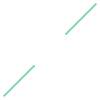

In [70]:
gdf.iloc[0]['geometry']

In [76]:
gdf.iloc[0]['geometry'].geoms

In [78]:
if isinstance(gdf.iloc[0]['geometry'], MultiLineString):
    points = [MultiPoint(line.coords) for line in gdf.iloc[0]['geometry'].geoms]
    print(points)

[<MULTIPOINT (0 0, 1 1)>, <MULTIPOINT (2 2, 3 3)>]


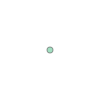

In [83]:
from shapely.geometry import Point,MultiPoint

Point(0,0)
MultiPoint([Point(0,0).coords])

In [68]:
def line_to_multipoint(geometry):
    if isinstance(geometry, LineString):
        return MultiPoint(geometry.coords)
    elif isinstance(geometry, MultiLineString):
        points = [MultiPoint(line.coords) for line in geometry]
        return MultiPoint([point for multi in points for point in multi])
    else:
        return geometry  # Return the original geometry if it's not a LineString or MultiLineString

# Apply the conversion function to each row in the GeoDataFrame
gdf["geometry"] = gdf["geometry"].apply(line_to_multipoint)


TypeError: 'MultiLineString' object is not iterable

In [86]:
from coastseg.merge_utils import merge_geometries

# create a list of geometries
geometries = [
    MultiPoint([(0, 0), (1, 1)]),
    MultiPoint([(2, 2), (3, 3)]),
    MultiPoint([(4, 4), (5, 5)]),
]
# create a dictionary with the other columns
data = {
    "geoaccuracy": [1, 2, 3],
    "cloud_cover": [0.1, 0.2, 0.3],
    "satname": ["L8", "L8", "L8"],
    "date": [
        pd.Timestamp("2018-12-30 18:22:25"),
        pd.Timestamp("2018-1-30 19:22:25"),
        pd.Timestamp("2022-01-03 19:22:25"),
    ],
    "geometry": geometries,
}
# create a GeoDataFrame from the dictionary
df = gpd.GeoDataFrame(data, geometry="geometry", crs="epsg:4326")
df

,geoaccuracy,cloud_cover,satname,date,geometry
0,1,0.1,L8,2018-12-30 18:22:25,"MULTIPOINT (0.00000 0.00000, 1.00000 1.00000)"
1,2,0.2,L8,2018-01-30 19:22:25,"MULTIPOINT (2.00000 2.00000, 3.00000 3.00000)"
2,3,0.3,L8,2022-01-03 19:22:25,"MULTIPOINT (4.00000 4.00000, 5.00000 5.00000)"


In [88]:
result = merge_geometries(df)
result

,geoaccuracy,cloud_cover,satname,date
0,1,0.1,L8,2018-12-30 18:22:25
1,2,0.2,L8,2018-01-30 19:22:25
2,3,0.3,L8,2022-01-03 19:22:25


In [118]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint, MultiLineString, LineString, Point

data = {
        "date": [
            pd.Timestamp("2018-12-30 18:22:25"),
            pd.Timestamp("2019-1-28 05:12:28"),
            pd.Timestamp("2020-5-23 19:24:27"),
        ],
        "geometry": [
            MultiPoint([(-117.45892, 33.28226), (-118.45892, 35.28226)]),
            MultiPoint([(-117.45881, 33.28239), (-120.45892, 40.28226)]),
            MultiPoint([(-117.45875, 33.28242)]),
        ],
        "geoaccuracy": [
            5.088,
            5.802,
            6.596,
        ],
        "satname": ["L8", "L8", "L8"],
        "cloud_cover": [0.0, 0.23, 0.263967],
    }
extracted_gdf1 = gpd.GeoDataFrame(data, crs="epsg:4326")
extracted_gdf1

,date,geometry,geoaccuracy,satname,cloud_cover
0,2018-12-30 18:22:25,"MULTIPOINT (-117.45892 33.28226, -118.45892 35...",5.088,L8,0.000000
1,2019-01-28 05:12:28,"MULTIPOINT (-117.45881 33.28239, -120.45892 40...",5.802,L8,0.230000
2,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967


In [10]:
# this is the gdf shares pd.Timestamp('2018-12-30 18:22:25') and  pd.Timestamp('2020-5-23 19:24:27') with extracted_gdf1
data = {
    "date": [
        pd.Timestamp("2018-12-30 18:22:25"),
        pd.Timestamp("2020-1-28 05:12:28"),
        pd.Timestamp("2020-5-23 19:24:27"),
    ],
    "geometry": [
        MultiPoint([(-117.44480, 33.26540)]),
        MultiPoint([(-117.45899, 33.28226)]),
        MultiPoint([(-117.45896, 33.28226)]),
    ],
    "geoaccuracy": [
        5.088,
        5.802,
        6.596,
    ],
    "satname": ["L8", "L8", "L8"],
    "cloud_cover": [0.0, 0.0, 0.263967],
}
extracted_gdf2 = gpd.GeoDataFrame(data, crs="epsg:4326")
extracted_gdf2 

,date,geometry,geoaccuracy,satname,cloud_cover
0,2018-12-30 18:22:25,MULTIPOINT (-117.44480 33.26540),5.088,L8,0.000000
1,2020-01-28 05:12:28,MULTIPOINT (-117.45899 33.28226),5.802,L8,0.000000
2,2020-05-23 19:24:27,MULTIPOINT (-117.45896 33.28226),6.596,L8,0.263967


In [102]:
data = {
    "date": [
        pd.Timestamp("2015-12-30 18:22:25"),
        pd.Timestamp("2019-1-28 05:12:28"),
        pd.Timestamp("2020-5-23 19:24:27"),
    ],
    "geometry": [
        MultiPoint([(-117.45896, 33.28226)]),
        MultiPoint([(-117.45894, 33.28226)]),
        MultiPoint([(-117.45891, 33.28232)]),
    ],
    "geoaccuracy": [
        5.088,
        5.802,
        6.596,
    ],
    "satname": ["L9", "L9", "L8"],
    "cloud_cover": [0.0, 0.1, 0.263967],
}
extracted_gdf3 = gpd.GeoDataFrame(data, crs="epsg:4326")
extracted_gdf3

,date,geometry,geoaccuracy,satname,cloud_cover
0,2015-12-30 18:22:25,MULTIPOINT (-117.45896 33.28226),5.088,L9,0.000000
1,2019-01-28 05:12:28,MULTIPOINT (-117.45894 33.28226),5.802,L9,0.100000
2,2020-05-23 19:24:27,MULTIPOINT (-117.45891 33.28232),6.596,L8,0.263967


In [114]:
from coastseg.merge_utils import merge_geodataframes

# merged_gdf = merge_geodataframes(['date', 'satname'],'inner', aggregation_funcs,'epsg:4326', *gdfs)
aggregation_funcs = {
    'cloud_cover': 'mean',
    'geoaccuracy': 'mean'
    }
merge_geodataframes( ['date', 'satname'],'inner',aggregation_funcs,'epsg:4326', extracted_gdf1, extracted_gdf2)

,date,geometry_left,satname,geometry_right,cloud_cover,geoaccuracy
0,2018-12-30 18:22:25,MULTIPOINT (-117.45892 33.28226),L8,MULTIPOINT (-117.44480 33.26540),0.000000,5.088
1,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),L8,MULTIPOINT (-117.45896 33.28226),0.263967,6.596


In [115]:
from coastseg.merge_utils import merge_geodataframes

# merged_gdf = merge_geodataframes(['date', 'satname'],'inner', aggregation_funcs,'epsg:4326', *gdfs)
aggregation_funcs = {
    'cloud_cover': 'mean',
    'geoaccuracy': 'mean'
    }
merge_geodataframes( ['date', 'satname'],'inner',aggregation_funcs,'epsg:4326', extracted_gdf1, extracted_gdf2, extracted_gdf3)

,date,geometry_left,satname,geometry_right,geometry,cloud_cover,geoaccuracy
0,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),L8,MULTIPOINT (-117.45896 33.28226),MULTIPOINT (-117.45891 33.28232),0.263967,6.596


In [ ]:
from coastseg.merge_utils import merge_geodataframes

# merged_gdf = merge_geodataframes(['date', 'satname'],'inner', aggregation_funcs,'epsg:4326', *gdfs)
aggregation_funcs = {
    'cloud_cover': 'mean',
    'geoaccuracy': 'mean'
    }

merge_geodataframes( ['date', 'satname'],'inner',aggregation_funcs,'epsg:4326', extracted_gdf1, extracted_gdf2, extracted_gdf3)

In [14]:
# this code did not work it  only found the dates in common across all the dataframes.
from functools import reduce

# Step 1: Find the common dates using set intersection
common_dates = set(extracted_gdf1['date']).intersection(extracted_gdf2['date'], extracted_gdf3['date'])

# Step 2: Filter the dataframes to only include rows with the common date
dfs_filtered = [df[df['date'].isin(common_dates)] for df in [extracted_gdf1, extracted_gdf2, extracted_gdf3]]

# Step 3: Perform a single merge operation on the filtered dataframes
final_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs_filtered)
final_df

,date,geometry_x,geoaccuracy_x,satname_x,cloud_cover_x,geometry_y,geoaccuracy_y,satname_y,cloud_cover_y,geometry,geoaccuracy,satname,cloud_cover
0,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45896 33.28226),6.596,L8,0.263967,MULTIPOINT (-117.45891 33.28232),6.596,L8,0.263967


In [16]:
# only got dates in common across all the dataframes
dfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

# Assuming dfs is a list of all your dataframes
common_dates = set(dfs[0]['date'])
for df in dfs[1:]:
    common_dates = common_dates.intersection(df['date'])

dfs_filtered = [df[df['date'].isin(common_dates)] for df in dfs]
final_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs_filtered)
final_df


,date,geometry_x,geoaccuracy_x,satname_x,cloud_cover_x,geometry_y,geoaccuracy_y,satname_y,cloud_cover_y,geometry,geoaccuracy,satname,cloud_cover
0,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45896 33.28226),6.596,L8,0.263967,MULTIPOINT (-117.45891 33.28232),6.596,L8,0.263967


In [18]:
from itertools import combinations

# Put all dataframes in a list
dfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

# Initialize an empty list to store the merged dataframes
merged_dfs = []

# Loop over all combinations of 2 dataframes
for df_a, df_b in combinations(dfs, 2):
    # Perform an 'inner' merge and append the result to the list
    merged_dfs.append(df_a.merge(df_b, on='date', how='inner'))

# Concatenate all the merged dataframes
final_df = pd.concat(merged_dfs)
final_df

,date,geometry_x,geoaccuracy_x,satname_x,cloud_cover_x,geometry_y,geoaccuracy_y,satname_y,cloud_cover_y
0,2018-12-30 18:22:25,MULTIPOINT (-117.45892 33.28226),5.088,L8,0.000000,MULTIPOINT (-117.44480 33.26540),5.088,L8,0.000000
1,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45896 33.28226),6.596,L8,0.263967
0,2019-01-28 05:12:28,MULTIPOINT (-117.45881 33.28239),5.802,L8,0.230000,MULTIPOINT (-117.45894 33.28226),5.802,L9,0.100000
1,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45891 33.28232),6.596,L8,0.263967
0,2020-05-23 19:24:27,MULTIPOINT (-117.45896 33.28226),6.596,L8,0.263967,MULTIPOINT (-117.45891 33.28232),6.596,L8,0.263967


In [24]:
from functools import reduce
import numpy as np

# only got dates in common across all the dataframes
dfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

def merge_and_average(df1, df2):
    # Perform a full outer join
    merged = pd.merge(df1, df2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))

    # Loop over all columns
    for column in set(df1.columns).intersection(df2.columns):
        # Skip non-numeric columns
        if not np.issubdtype(df1[column].dtype, np.number):
            continue

        # Average the values in the two columns
        merged[column] = merged[[f'{column}_df1', f'{column}_df2']].mean(axis=1)

    # Drop the original columns
    merged.drop(columns=[col for col in merged.columns if '_df1' in col or '_df2' in col], inplace=True)

    return merged


# Perform a full outer join and average the numeric columns across all dataframes
result = reduce(merge_and_average, dfs)

TypeError: Cannot interpret '<geopandas.array.GeometryDtype object at 0x0000022FDF703910>' as a data type

In [46]:
from shapely.ops import unary_union
merged = pd.merge(extracted_gdf1, extracted_gdf2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))
# Loop over all columns
for column in set(extracted_gdf1.columns).intersection(extracted_gdf2.columns):
    # Skip non-numeric columns
    # print(extracted_gdf1[column])
    print(extracted_gdf1[column].dtype)
    if isinstance(extracted_gdf1[column].dtype, gpd.array.GeometryDtype):
        columns = [col for col in merged.columns if "geometry" in col]
        merged["geometry"] = merged[columns].apply(
            lambda row: unary_union(row.tolist()), axis=1
        )
        # drop the rows that  were merged
        merged.drop(columns=[f'{column}_df1', f'{column}_df2'], inplace=True)
        continue
    if not np.issubdtype(extracted_gdf1[column].dtype, np.number):
            continue
    # if not pd.api.types.is_numeric_dtype(extracted_gdf1[column]):
    #     continue
    print(extracted_gdf1[column])
    # Average the values in the two columns
    merged[column] = merged[[f'{column}_df1', f'{column}_df2']].mean(axis=1)
    merged.drop(columns=[f'{column}_df1', f'{column}_df2'], inplace=True)
    
merged

float64
0    0.000000
1    0.230000
2    0.263967
Name: cloud_cover, dtype: float64
float64
0    5.088
1    5.802
2    6.596
Name: geoaccuracy, dtype: float64
object
datetime64[ns]
geometry


,date,satname,cloud_cover,geoaccuracy,geometry
0,2018-12-30 18:22:25,L8,0.000000,5.088,"MULTIPOINT (-117.45892 33.28226, -117.44480 33..."
1,2019-01-28 05:12:28,L8,0.230000,5.802,POINT (-117.45881 33.28239)
2,2020-05-23 19:24:27,L8,0.263967,6.596,"MULTIPOINT (-117.45896 33.28226, -117.45875 33..."
3,2020-01-28 05:12:28,L8,0.000000,5.802,POINT (-117.45899 33.28226)


In [50]:
from shapely.ops import unary_union
from coastseg.merge_utils import merge_geometries

merged = pd.merge(extracted_gdf1, extracted_gdf2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))
# Loop over all columns
for column in set(extracted_gdf1.columns).intersection(extracted_gdf2.columns):
    # merge the geometries
    if isinstance(extracted_gdf1[column].dtype, gpd.array.GeometryDtype):
        merged = merge_geometries(merged, columns=[f'{column}_df1', f'{column}_df2'], operation=unary_union)
        continue
    # Skip non-numeric columns
    if not np.issubdtype(extracted_gdf1[column].dtype, np.number):
            continue
    # Average the values in the two columns
    merged[column] = merged[[f'{column}_df1', f'{column}_df2']].mean(axis=1)
    merged.drop(columns=[f'{column}_df1', f'{column}_df2'], inplace=True)
    
merged

,date,satname,cloud_cover,geoaccuracy,geometry
0,2018-12-30 18:22:25,L8,0.000000,5.088,"MULTIPOINT (-117.45892 33.28226, -117.44480 33..."
1,2019-01-28 05:12:28,L8,0.230000,5.802,POINT (-117.45881 33.28239)
2,2020-05-23 19:24:27,L8,0.263967,6.596,"MULTIPOINT (-117.45896 33.28226, -117.45875 33..."
3,2020-01-28 05:12:28,L8,0.000000,5.802,POINT (-117.45899 33.28226)


In [119]:
from shapely.ops import unary_union
from coastseg.merge_utils import merge_geometries
from functools import reduce
import pandas as pd


def merge_geometries(merged_gdf, columns=None, operation=unary_union):
    """
    Performs a specified operation for the geometries with the same date and satname.

    Parameters:
    merged_gdf : GeoDataFrame
        The GeoDataFrame to perform the operation on.
    columns : list of str, optional
        The columns to perform the operation on. If None, all columns with 'geometry' in the name are used.
    operation : function, optional
        The operation to perform. If None, unary_union is used.

    Returns:
    GeoDataFrame
        The GeoDataFrame with the operation performed.
    """
    if columns is None:
        columns = [col for col in merged_gdf.columns if "geometry" in col]
    else:
        columns = [col for col in columns if col in merged_gdf.columns]

    merged_gdf["geometry"] = merged_gdf[columns].apply(
        lambda row: operation(row.tolist()), axis=1
    )
    for col in columns:
        if col in merged_gdf.columns:
            merged_gdf = merged_gdf.drop(columns=col)
    return merged_gdf

def merge_and_average(df1, df2):
    # Perform a full outer join
    merged = pd.merge(df1, df2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))

    # Loop over all columns
    for column in set(df1.columns).intersection(df2.columns):
        # Merge the geometries
        
        if isinstance(df1[column].dtype, gpd.array.GeometryDtype):
            print(f"merging {{['{column}_df1', '{column}_df2']}}")
            print(df1[column])
            print(df2[column])
            # merged = merge_geometries(merged, columns=[f'{column}_df1', f'{column}_df2'], operation=unary_union)
            merged = merge_geometries(merged)
            continue
        # Skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(df1[column]):
            continue
        # Average the values in the two columns
        merged[column] = merged[[f'{column}_df1', f'{column}_df2']].mean(axis=1)
        merged.drop(columns=[f'{column}_df1', f'{column}_df2'], inplace=True)

    return merged

# List of GeoDataFrames
gdfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

# Perform a full outer join and average the numeric columns across all GeoDataFrames
result = reduce(merge_and_average, gdfs)

result
    

merging {['geometry_df1', 'geometry_df2']}
0    MULTIPOINT (-117.45892 33.28226, -118.45892 35...
1    MULTIPOINT (-117.45881 33.28239, -120.45892 40...
2                     MULTIPOINT (-117.45875 33.28242)
Name: geometry, dtype: geometry
0    MULTIPOINT (-117.44480 33.26540)
1    MULTIPOINT (-117.45899 33.28226)
2    MULTIPOINT (-117.45896 33.28226)
Name: geometry, dtype: geometry
merging {['geometry_df1', 'geometry_df2']}
0    MULTIPOINT (-118.45892 35.28226, -117.45892 33...
1    MULTIPOINT (-120.45892 40.28226, -117.45881 33...
2    MULTIPOINT (-117.45896 33.28226, -117.45875 33...
3                          POINT (-117.45899 33.28226)
Name: geometry, dtype: geometry
0    MULTIPOINT (-117.45896 33.28226)
1    MULTIPOINT (-117.45894 33.28226)
2    MULTIPOINT (-117.45891 33.28232)
Name: geometry, dtype: geometry


,date,satname,cloud_cover,geoaccuracy,geometry
0,2018-12-30 18:22:25,L8,0.000000,5.088,"MULTIPOINT (-118.45892 35.28226, -117.45892 33..."
1,2019-01-28 05:12:28,L8,0.230000,5.802,"MULTIPOINT (-120.45892 40.28226, -117.45881 33..."
2,2020-05-23 19:24:27,L8,0.263967,6.596,"MULTIPOINT (-117.45896 33.28226, -117.45891 33..."
3,2020-01-28 05:12:28,L8,0.000000,5.802,POINT (-117.45899 33.28226)
4,2015-12-30 18:22:25,L9,0.000000,5.088,POINT (-117.45896 33.28226)
5,2019-01-28 05:12:28,L9,0.100000,5.802,POINT (-117.45894 33.28226)


In [112]:
merged = pd.merge(extracted_gdf1, extracted_gdf2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))
# Loop over all columns
for column in set(extracted_gdf1.columns).intersection(extracted_gdf2.columns):
    # Merge the geometries
    
    
    if isinstance(extracted_gdf1[column].dtype, gpd.array.GeometryDtype):
        print(column)
        print(f"merging {{['{column}_df1', '{column}_df2']}}")
        print(extracted_gdf1[column])
        print(extracted_gdf2[column])
        # merged = merge_geometries(merged, columns=[f'{column}_df1', f'{column}_df2'], operation=unary_union)
        merged = merge_geometries(merged)

geometry
merging {['geometry_df1', 'geometry_df2']}
0    MULTIPOINT (-117.45892 33.28226)
1    MULTIPOINT (-117.45881 33.28239)
2    MULTIPOINT (-117.45875 33.28242)
Name: geometry, dtype: geometry
0    MULTIPOINT (-117.44480 33.26540)
1    MULTIPOINT (-117.45899 33.28226)
2    MULTIPOINT (-117.45896 33.28226)
Name: geometry, dtype: geometry


In [116]:
merged = pd.merge(extracted_gdf1, extracted_gdf2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))

In [117]:
merged

,date,geometry_df1,geoaccuracy_df1,satname,cloud_cover_df1,geometry_df2,geoaccuracy_df2,cloud_cover_df2
0,2018-12-30 18:22:25,MULTIPOINT (-117.45892 33.28226),5.088,L8,0.000000,MULTIPOINT (-117.44480 33.26540),5.088,0.000000
1,2019-01-28 05:12:28,MULTIPOINT (-117.45881 33.28239),5.802,L8,0.230000,None,NaN,NaN
2,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45896 33.28226),6.596,0.263967
3,2020-01-28 05:12:28,None,NaN,L8,NaN,MULTIPOINT (-117.45899 33.28226),5.802,0.000000


In [113]:
merged_gdf =  merged

if columns is None:
    columns = [col for col in merged_gdf.columns if "geometry" in col]
else:
    columns = [col for col in columns if col in merged_gdf.columns]
merged_gdf["geometry"] = merged_gdf[columns].apply(
    lambda row: unary_union(row.tolist()), axis=1
)
for col in columns:
    if col in merged_gdf.columns:
        merged_gdf = merged_gdf.drop(columns=col)
        
merged_gdf


NameError: name 'merged_gdf' is not defined

In [104]:
result.sort_values(by='date', inplace=True)
result.reset_index(drop=True, inplace=True)
result

,date,satname,cloud_cover,geoaccuracy,geometry
0,2015-12-30 18:22:25,L9,0.000000,5.088,POINT (-117.45896 33.28226)
1,2018-12-30 18:22:25,L8,0.000000,5.088,"MULTIPOINT (-117.45892 33.28226, -117.44480 33..."
2,2019-01-28 05:12:28,L8,0.230000,5.802,POINT (-117.45881 33.28239)
3,2019-01-28 05:12:28,L9,0.100000,5.802,POINT (-117.45894 33.28226)
4,2020-01-28 05:12:28,L8,0.000000,5.802,POINT (-117.45899 33.28226)
5,2020-05-23 19:24:27,L8,0.263967,6.596,"MULTIPOINT (-117.45896 33.28226, -117.45891 33..."


In [88]:
from typing import List, Optional, Union
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
from coastseg.merge_utils import merge_geometries


def merge_and_average(df1: gpd.GeoDataFrame, df2: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Perform a full outer join
    merged = pd.merge(df1, df2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))

    # Identify numeric columns from both dataframes
    numeric_columns_df1 = df1.select_dtypes(include='number').columns
    numeric_columns_df2 = df2.select_dtypes(include='number').columns
    common_numeric_columns = set(numeric_columns_df1).intersection(numeric_columns_df2)

    # Average the numeric columns
    for column in common_numeric_columns:
        merged[column] = merged[[f'{column}_df1', f'{column}_df2']].mean(axis=1)

    # Drop the original numeric columns
    merged.drop(columns=[f'{column}_df1' for column in common_numeric_columns] + [f'{column}_df2' for column in common_numeric_columns], inplace=True)

    # Merge geometries
    geometry_columns = [col for col in merged.columns if 'geometry' in col]
    merged = merge_geometries(merged, columns=geometry_columns)

    return merged

# List of GeoDataFrames
gdfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

# Perform a full outer join and average the numeric columns across all GeoDataFrames
result = reduce(merge_and_average, gdfs)

result


,date,satname,cloud_cover,geoaccuracy,geometry
0,2018-12-30 18:22:25,L8,0.000000,5.088,"MULTIPOINT (-117.45892 33.28226, -117.44480 33..."
1,2019-01-28 05:12:28,L8,0.230000,5.802,POINT (-117.45881 33.28239)
2,2020-05-23 19:24:27,L8,0.263967,6.596,"MULTIPOINT (-117.45896 33.28226, -117.45891 33..."
3,2020-01-28 05:12:28,L8,0.000000,5.802,POINT (-117.45899 33.28226)
4,2015-12-30 18:22:25,L9,0.000000,5.088,POINT (-117.45896 33.28226)
5,2019-01-28 05:12:28,L9,0.100000,5.802,POINT (-117.45894 33.28226)


In [72]:

# Perform a full outer join
merged = pd.merge(extracted_gdf1, extracted_gdf2, on=['satname', 'date'], how='outer', suffixes=('_df1', '_df2'))
# Identify numeric columns from both dataframes
numeric_columns_df1 = extracted_gdf1.select_dtypes(include='number').columns
numeric_columns_df2 = extracted_gdf2.select_dtypes(include='number').columns
common_numeric_columns = set(numeric_columns_df1).intersection(numeric_columns_df2)
# Average the numeric columns
for column in common_numeric_columns:
    merged[column] = merged[[f'{column}_df1', f'{column}_df2']].mean(axis=1)
# Drop the original numeric columns
merged.drop(columns=[f'{column}_df1' for column in common_numeric_columns] + [f'{column}_df2' for column in common_numeric_columns], inplace=True)
# Merge geometries
geometry_columns = [col for col in merged.columns if 'geometry' in col]
merged




,date,geometry_df1,satname,geometry_df2,cloud_cover,geoaccuracy
0,2018-12-30 18:22:25,MULTIPOINT (-117.45892 33.28226),L8,MULTIPOINT (-117.44480 33.26540),0.000000,5.088
1,2019-01-28 05:12:28,MULTIPOINT (-117.45881 33.28239),L8,None,0.230000,5.802
2,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),L8,MULTIPOINT (-117.45896 33.28226),0.263967,6.596
3,2020-01-28 05:12:28,None,L8,MULTIPOINT (-117.45899 33.28226),0.000000,5.802


In [81]:
if columns is None:
    columns = [col for col in merged.columns if "geometry" in col]
columns
# # Use groupby and agg to perform the operation more efficiently
geometries = merged.groupby(['satname', 'date'])[columns].agg(unary_union)
geometries

geometry_df1  \
satname date                                               
L8      2018-12-30 18:22:25  POINT (-117.45892 33.28226)   
        2019-01-28 05:12:28  POINT (-117.45881 33.28239)   
        2020-01-28 05:12:28     GEOMETRYCOLLECTION EMPTY   
        2020-05-23 19:24:27  POINT (-117.45875 33.28242)   

                                            geometry_df2  
satname date                                              
L8      2018-12-30 18:22:25  POINT (-117.44480 33.26540)  
        2019-01-28 05:12:28     GEOMETRYCOLLECTION EMPTY  
        2020-01-28 05:12:28  POINT (-117.45899 33.28226)  
        2020-05-23 19:24:27  POINT (-117.45896 33.28226)

In [ ]:
if columns is None:
    columns = [col for col in merged.columns if "geometry" in col]

# Concatenate the geometry columns into a list
merged['geometry_list'] = merged[columns].values.tolist()

# Apply unary_union to each list of geometries
merged['geometry'] = merged['geometry_list'].apply(unary_union)

# Drop the original geometry columns and the 'geometry_list' column
merged.drop(columns=columns + ['geometry_list'], inplace=True)

merged

In [82]:
geometries.iloc[0][columns].agg(unary_union)

geometry_df1    POINT (-117.45892 33.28226)
geometry_df2      POINT (-117.4448 33.2654)
Name: (L8, 2018-12-30 18:22:25), dtype: object

In [83]:
combined_geometry = unary_union(geometries[columns].values)

In [85]:
geometries[columns].values

array([[<POINT (-117.459 33.282)>, <POINT (-117.445 33.265)>],
       [<POINT (-117.459 33.282)>, <GEOMETRYCOLLECTION EMPTY>],
       [<GEOMETRYCOLLECTION EMPTY>, <POINT (-117.459 33.282)>],
       [<POINT (-117.459 33.282)>, <POINT (-117.459 33.282)>]],
      dtype=object)

In [86]:
print(combined_geometry)

MULTIPOINT (-117.45899 33.28226, -117.45896 33.28226, -117.45892 33.28226, -117.45881 33.28239, -117.45875 33.28242, -117.4448 33.2654)


In [77]:
geometries = geometries.rename(columns={columns[0]: 'geometry'})

In [78]:
geometries

geometry  \
satname date                                               
L8      2018-12-30 18:22:25  POINT (-117.45892 33.28226)   
        2019-01-28 05:12:28  POINT (-117.45881 33.28239)   
        2020-01-28 05:12:28     GEOMETRYCOLLECTION EMPTY   
        2020-05-23 19:24:27  POINT (-117.45875 33.28242)   

                                            geometry_df2  
satname date                                              
L8      2018-12-30 18:22:25  POINT (-117.44480 33.26540)  
        2019-01-28 05:12:28     GEOMETRYCOLLECTION EMPTY  
        2020-01-28 05:12:28  POINT (-117.45899 33.28226)  
        2020-05-23 19:24:27  POINT (-117.45896 33.28226)

In [73]:
if columns is None:
    columns = [col for col in merged.columns if "geometry" in col]
columns
# # Use groupby and agg to perform the operation more efficiently
geometries = merged.groupby(['satname', 'date'])[columns].agg(unary_union)
geometries
# # Create a new GeoDataFrame
# return gpd.GeoDataFrame(merged_gdf.drop(columns=columns).join(geometries))

merged.drop(columns=columns)

,date,satname,cloud_cover,geoaccuracy
0,2018-12-30 18:22:25,L8,0.000000,5.088
1,2019-01-28 05:12:28,L8,0.230000,5.802
2,2020-05-23 19:24:27,L8,0.263967,6.596
3,2020-01-28 05:12:28,L8,0.000000,5.802


In [75]:
# Drop the geometry columns from the merged DataFrame
merged_no_geo = merged.drop(columns=columns)

# Merge the geometries back into the DataFrame
result = pd.merge(merged_no_geo, geometries, on=['satname', 'date'], how='left')
result

,date,satname,cloud_cover,geoaccuracy,geometry_df1,geometry_df2
0,2018-12-30 18:22:25,L8,0.000000,5.088,POINT (-117.45892 33.28226),POINT (-117.44480 33.26540)
1,2019-01-28 05:12:28,L8,0.230000,5.802,POINT (-117.45881 33.28239),GEOMETRYCOLLECTION EMPTY
2,2020-05-23 19:24:27,L8,0.263967,6.596,POINT (-117.45875 33.28242),POINT (-117.45896 33.28226)
3,2020-01-28 05:12:28,L8,0.000000,5.802,GEOMETRYCOLLECTION EMPTY,POINT (-117.45899 33.28226)


In [71]:
merged = merged.reset_index()  # Reset the index of the merged DataFrame
geometries = geometries.reset_index()  # Reset the index of the geometries DataFrame
result = gpd.GeoDataFrame(merged.drop(columns=columns).join(geometries, lsuffix='_merged', rsuffix='_geometries'))
result

,index,date_merged,satname_merged,cloud_cover,geoaccuracy,satname_geometries,date_geometries,geometry_df1,geometry_df2
0,0,2018-12-30 18:22:25,L8,0.000000,5.088,L8,2018-12-30 18:22:25,POINT (-117.45892 33.28226),POINT (-117.44480 33.26540)
1,1,2019-01-28 05:12:28,L8,0.230000,5.802,L8,2019-01-28 05:12:28,POINT (-117.45881 33.28239),GEOMETRYCOLLECTION EMPTY
2,2,2020-05-23 19:24:27,L8,0.263967,6.596,L8,2020-01-28 05:12:28,GEOMETRYCOLLECTION EMPTY,POINT (-117.45899 33.28226)
3,3,2020-01-28 05:12:28,L8,0.000000,5.802,L8,2020-05-23 19:24:27,POINT (-117.45875 33.28242),POINT (-117.45896 33.28226)


In [57]:
geometry_columns

['geometry_df1', 'geometry_df2']

In [58]:
merged["geometry"] = merged[geometry_columns].apply(
        lambda row: unary_union(row.tolist()), axis=1
    )

In [59]:
merged

,date,geometry_df1,satname,geometry_df2,cloud_cover,geoaccuracy,geometry
0,2018-12-30 18:22:25,MULTIPOINT (-117.45892 33.28226),L8,MULTIPOINT (-117.44480 33.26540),0.000000,5.088,"MULTIPOINT (-117.45892 33.28226, -117.44480 33..."
1,2019-01-28 05:12:28,MULTIPOINT (-117.45881 33.28239),L8,None,0.230000,5.802,POINT (-117.45881 33.28239)
2,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),L8,MULTIPOINT (-117.45896 33.28226),0.263967,6.596,"MULTIPOINT (-117.45896 33.28226, -117.45875 33..."
3,2020-01-28 05:12:28,None,L8,MULTIPOINT (-117.45899 33.28226),0.000000,5.802,POINT (-117.45899 33.28226)


In [ ]:
from collections import Counter

# Put all dataframes in a list
gdfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

# Initialize counters for dates and satellite names
date_counter = Counter()
satname_counter = Counter()

# Loop over all dataframes
for gdf in gdfs:
    # Update the counters with the dates and satellite names from the current dataframe
    date_counter.update(gdf['date'])
    satname_counter.update(gdf['satname'])

# Now date_counter and satname_counter are dictionaries where the keys are the dates and satellite names,
# and the values are the number of times each date or satellite name appears across all dataframes.

In [19]:
from collections import Counter

# Put all dataframes in a list
gdfs = [extracted_gdf1, extracted_gdf2, extracted_gdf3]

# Initialize a counter for the combined values
combined_counter = Counter()

# Loop over all dataframes
for gdf in gdfs:
    # Combine the 'date' and 'satname' into a single value and update the counter with these values
    combined_counter.update(gdf['date'].astype(str) + '_' + gdf['satname'])

# Now combined_counter is a dictionary where the keys are the combined 'date' and 'satname' values,
# and the values are the number of times each combined value appears across all dataframes.

In [20]:
combined_counter

Counter({'2020-05-23 19:24:27_L8': 3,
         '2018-12-30 18:22:25_L8': 2,
         '2019-01-28 05:12:28_L8': 1,
         '2020-01-28 05:12:28_L8': 1,
         '2015-12-30 18:22:25_L9': 1,
         '2019-01-28 05:12:28_L9': 1})

In [22]:
# Create a new Counter that only includes items with a count of 2 or more
filtered_counter = Counter({k: v for k, v in combined_counter.items() if v >= 2})
filtered_counter

Counter({'2020-05-23 19:24:27_L8': 3, '2018-12-30 18:22:25_L8': 2})

In [8]:
# Perform an 'inner' merge between each pair of DataFrames
merge_df1_df2 = extracted_gdf1.merge(extracted_gdf2, on=['date', 'satname'], how='inner')
merge_df1_df3 = extracted_gdf1.merge(extracted_gdf3, on=['date', 'satname'], how='inner')
merge_df2_df3 = extracted_gdf2.merge(extracted_gdf3, on=['date', 'satname'], how='inner')

# Concatenate the results
final_df = pd.concat([merge_df1_df2, merge_df1_df3, merge_df2_df3])

# Drop duplicates
final_df = final_df.drop_duplicates()

In [9]:
final_df

,date,geometry_x,geoaccuracy_x,satname,cloud_cover_x,geometry_y,geoaccuracy_y,cloud_cover_y
0,2018-12-30 18:22:25,MULTIPOINT (-117.45892 33.28226),5.088,L8,0.000000,MULTIPOINT (-117.44480 33.26540),5.088,0.000000
1,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45896 33.28226),6.596,0.263967
0,2020-05-23 19:24:27,MULTIPOINT (-117.45875 33.28242),6.596,L8,0.263967,MULTIPOINT (-117.45891 33.28232),6.596,0.263967
0,2020-05-23 19:24:27,MULTIPOINT (-117.45896 33.28226),6.596,L8,0.263967,MULTIPOINT (-117.45891 33.28232),6.596,0.263967
